# Flatiron Health mCRC: MICE

**OBJECTIVE: Impute missing variables in the training dataset using multiple imputation chained equations (MICE). Five non-missing training sets will be construced using MICE along with 5 test sets. A gradient boosting model will be fit to each training dataset and a test set AUC will be calculated. The 1 year AUCs from the test set will be pooled to get a final estimate.** 

**BACKGROUND: The variables with the most missingness at time of advanced diagnosis are ECOG (50%), labs (30%), and changes in weight (11%). These three variables have high predictive value in our models. Up until this point, missingness has been handled by making "unknown" a level in the ECOG variable and imputing median for lab values and weight loss. While this imputation strategy is simple and fast, it likely understimates the variance of variables and disturb relations between variables when the data is not missing completely at random.** 

**Variables that will be imputed with MICE:** 
1. **ECOG (50% missing)**
2. **BMI (25% missing)**
3. **Weight (25% missing)**
4. **Percent change in weight and weight slope (20% missing)**
5. **Socioeconomic status (25% missing)**
6. **Stage (10%)**
7. **Labs at time of advanced diagnosis (30% missing)**
8. **Subset of summary labs (40% missing)**

**Five complete training sets will be imputed using the Python package "miceforest" which uses lightgbm as a backend. Five complete test sets will also be imputed from the final model used to impute the training set values. All existing variables including outcome variables like death status and time until event will be utilized to aid in the imputations. In addition, auxillary variables such as receipt of treatment, weight and BMI at 3 months, and labs at 3 months will be created to augment imputations.**   

**After complete training and test sets are constructed, a gradient boosting survival model will be built for each training set in the same fashion as in the crude imputation notebook. Final test AUCs will be pooled using Rubin's rules.**

**OUTLINE:**
1. **Building auxillary variables** 
2. **Performing MICE on training and test sets** 
3. **Building gradient boosting models on imputed datasets**
4. **Pooling results**

## 1. Building auxillary varibles 

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

### 1.1 Preprocessing

In [3]:
train = pd.read_csv('train_full.csv')
row_ID(train)

(27452, 27452)

In [4]:
test = pd.read_csv('test_full.csv')
row_ID(test)

(6863, 6863)

In [5]:
df = pd.concat([train, test], ignore_index = True)
row_ID(df)

(34315, 34315)

### 1.2 Treatment 

**Add indicator variables for first, second, and third line treatment. Treatment will be defined as having received an FDA approved targeted agent for the treatment of metastatic colorectal cancer.** 

In [6]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [7]:
line_therapy = line_therapy[line_therapy['PatientID'].isin(df['PatientID'])]

In [8]:
# List of FDA approved drugs for mCRC as of December 2022. Clinical study drug is also included. 
fda_yes = [
    'Aflibercept',
    'Ziv-Aflibercept',
    'Bevacizumab',
    'Bevacizumab-Awwb',
    'Bevacizumab-Bvzr',
    'Capecitabine',
    'CAPEOX',
    'Cetuximab',
    'Encorafenib',
    'Entrectinib',
    'Fluorouracil',
    'FOLFIRI',
    'FOLFOX',
    'FOLFOXIRI',
    'Ipilimumab ',
    'Irinotecan',
    'Larotrectinib',
    'Nivolumab',
    'Oxaliplatin',
    'Panitumumab',
    'Pembrolizumab',
    'Ramucirumab',
    'Regorafenib',
    'Trifluridine/Tipiracil',
    'Clinical Study Drug'
]

In [9]:
line_therapy_1 = (
    line_therapy.query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
    .drop_duplicates(subset = 'PatientID', keep = 'first'))

line_therapy_2 = (
    line_therapy.query('LineNumber == 2')
    .query('IsMaintenanceTherapy == False')
    .drop_duplicates(subset = 'PatientID', keep = 'first'))

line_therapy_3 = (
    line_therapy.query('LineNumber == 3')
    .query('IsMaintenanceTherapy == False')
    .drop_duplicates(subset = 'PatientID', keep = 'first'))

line_therapy_4 = (
    line_therapy.query('LineNumber == 4')
    .query('IsMaintenanceTherapy == False')
    .drop_duplicates(subset = 'PatientID', keep = 'first'))

In [10]:
line_therapy_1.loc[:, 'line_1'] = np.where(
    line_therapy_1['LineName'].str.contains('|'.join(fda_yes)), 1, 0)

line_therapy_2.loc[:, 'line_2'] = np.where(
    line_therapy_2['LineName'].str.contains('|'.join(fda_yes)), 1, 0)

line_therapy_3.loc[:, 'line_3'] = np.where(
    line_therapy_3['LineName'].str.contains('|'.join(fda_yes)), 1, 0)

line_therapy_4.loc[:, 'line_4'] = np.where(
    line_therapy_4['LineName'].str.contains('|'.join(fda_yes)), 1, 0)

In [11]:
line_therapy_1 = line_therapy_1[['PatientID', 'line_1']]
line_therapy_2 = line_therapy_2[['PatientID', 'line_2']]
line_therapy_3 = line_therapy_3[['PatientID', 'line_3']]
line_therapy_4 = line_therapy_4[['PatientID', 'line_4']]

In [12]:
df = pd.merge(df, line_therapy_1, on = 'PatientID', how = 'outer')
df = pd.merge(df, line_therapy_2, on = 'PatientID', how = 'outer')
df = pd.merge(df, line_therapy_3, on = 'PatientID', how = 'outer')
df = pd.merge(df, line_therapy_4, on = 'PatientID', how = 'outer')

In [13]:
df[['line_1', 'line_2', 'line_3', 'line_4']] = df[['line_1', 'line_2', 'line_3', 'line_4']].fillna(value = 0)

In [14]:
df.line_1.value_counts()

1.0    26915
0.0     7400
Name: line_1, dtype: int64

In [15]:
df.line_2.value_counts()

0.0    20148
1.0    14167
Name: line_2, dtype: int64

In [16]:
df.line_3.value_counts()

0.0    27069
1.0     7246
Name: line_3, dtype: int64

In [17]:
df.line_4.value_counts()

0.0    30767
1.0     3548
Name: line_4, dtype: int64

In [18]:
row_ID(df)

(34315, 34315)

In [19]:
%whos DataFrame

Variable         Type         Data/Info
---------------------------------------
df               DataFrame               PatientID gend<...>34315 rows x 228 columns]
line_therapy     DataFrame               PatientID     <...>n[63375 rows x 9 columns]
line_therapy_1   DataFrame               PatientID  lin<...>n[27309 rows x 2 columns]
line_therapy_2   DataFrame               PatientID  lin<...>n[14445 rows x 2 columns]
line_therapy_3   DataFrame               PatientID  lin<...>\n[7406 rows x 2 columns]
line_therapy_4   DataFrame               PatientID  lin<...>\n[3651 rows x 2 columns]
test             DataFrame              PatientID gende<...>[6863 rows x 224 columns]
train            DataFrame               PatientID gend<...>27452 rows x 224 columns]


In [20]:
del line_therapy
del line_therapy_1
del line_therapy_2
del line_therapy_3
del line_therapy_4

### 1.3 Weight

In [21]:
vitals = pd.read_csv('Vitals.csv')

vitals = vitals[vitals['PatientID'].isin(df['PatientID'])]

/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [22]:
enhanced_met = enhanced_met = pd.read_csv('Enhanced_MetastaticCRC.csv')

enhanced_met = enhanced_met[enhanced_met['PatientID'].isin(df['PatientID'])]
                                                              
enhanced_met.loc[:, 'MetDiagnosisDate'] = pd.to_datetime(enhanced_met['MetDiagnosisDate'])

enhanced_met = enhanced_met.rename(columns = {'MetDiagnosisDate': 'met_date'})

#### Weight and BMI

In [23]:
# Create weight dataframe; remove weight values that are empty or equal to zero.
weight = (
    vitals
    .query('Test == "body weight"')
    .filter(items = ['PatientID', 'TestDate', 'TestResultCleaned'])
    .rename(columns = {'TestResultCleaned': 'weight'})
    .dropna(subset = ['weight'])
    .query('weight != 0')
)

In [24]:
weight.loc[:, 'TestDate'] = pd.to_datetime(weight['TestDate'])

In [25]:
weight = pd.merge(weight, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [26]:
# Weight elgibliity window is -60 to +60 from 6 months after metastatic diagnosis. 
weight_win_bmi = (
    weight
    .assign(weight_date_diff = ((weight['TestDate'] - (weight['met_date'] + pd.DateOffset(days = 180))).dt.days))
    .query('weight_date_diff >= -60 and weight_date_diff <= 60')
)

In [27]:
weight_win_bmi.loc[:, 'weight_date_diff'] = weight_win_bmi['weight_date_diff'].abs()

In [28]:
# Select weight closest to +180 from metastatic diagnosis; lowest weight selected in the event of two weights on same day or equidistant. 
weight_bmi_wide = (
    weight_win_bmi
    .sort_values(by = ['PatientID', 'weight_date_diff', 'weight'], ascending = [True, True, True])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    .filter(items = ['PatientID', 'weight'])
    .rename(columns = {'weight': 'weight_180'})
)

In [29]:
# Dataframe of average height for each patient. 
height_avg = (
    vitals
    .query('Test == "body height"')
    .filter(items = ['PatientID', 'TestResultCleaned'])
    .groupby('PatientID')['TestResultCleaned'].mean()
    .to_frame()
    .reset_index()
    .rename(columns = {'TestResultCleaned': 'height_avg'})
)

In [30]:
weight_bmi_wide = pd.merge(weight_bmi_wide, height_avg, on = 'PatientID', how = 'left')

In [31]:
# Create BMI column. 
weight_bmi_wide = (
    weight_bmi_wide
    .assign(bmi_180 = lambda x: (x['weight_180']/(x['height_avg']*x['height_avg']))*10000)
    .drop(columns = ['height_avg'])
)

In [32]:
df = pd.merge(df, weight_bmi_wide, on = 'PatientID', how = 'outer')

In [33]:
row_ID(df)

(34315, 34315)

#### Percent change in weight 

In [34]:
# Select elgbility window of -90 to +365 days from metastatic diagnosis.
weight_win_summary = (
    weight
    .assign(weight_date_diff = (weight['TestDate'] - weight['met_date']).dt.days)
    .query('weight_date_diff >= -90 and weight_date_diff <= 365')
)

In [35]:
# Select patients with more than 1 weight recording within elgibility window.
weight_win_summary = weight_win_summary[weight_win_summary.duplicated(subset = ['PatientID'], keep = False)]

In [36]:
# Select weight from the earliest time within elgibility window. 
weight_tmin = weight_win_summary.loc[weight_win_summary.groupby('PatientID')['weight_date_diff'].idxmin()]

In [37]:
# Select weight from the latest time within elgibility window. 
weight_tmax = weight_win_summary.loc[weight_win_summary.groupby('PatientID')['weight_date_diff'].idxmax()]

In [38]:
# Combine above two dataframes and sort from earliest recorded weight to latest recorded weight for each patient. 
weight_tcomb = (
    pd.concat([weight_tmin, weight_tmax])
    .sort_values(by = ['PatientID', 'weight_date_diff'], ascending = True)
)

In [39]:
weight_tcomb.loc[:, 'weight_pct_1yr'] = weight_tcomb.groupby('PatientID')['weight'].pct_change()

In [40]:
# Drop empty rows for weight_pct_change.
weight_pct_wide = (
    weight_tcomb
    .dropna(subset = ['weight_pct_1yr'])
    .filter(items = ['PatientID', 'weight_pct_1yr'])
)

In [41]:
df = pd.merge(df, weight_pct_wide, on = 'PatientID', how = 'outer')

In [42]:
row_ID(df)

(34315, 34315)

#### Slope of weight 

In [43]:
import datetime as dt
from scipy.stats import linregress 

In [44]:
weight_win_summary.loc[:, 'date_ordinal'] = weight_win_summary['TestDate'].map(dt.datetime.toordinal)

In [45]:
# Dataframe of slope for weight recordings within window period (kg/day).
weight_slope_wide = (
    weight_win_summary
    .groupby('PatientID')
    .apply(lambda x: pd.Series(linregress(x['date_ordinal'], x['weight'])))
    .rename(columns = {0: 'weight_slope_1yr'})
    .reset_index()
    .filter(items = ['PatientID', 'weight_slope_1yr'])) 

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm


In [46]:
df = pd.merge(df, weight_slope_wide, on = 'PatientID', how = 'outer')

In [47]:
row_ID(df)

(34315, 34315)

In [48]:
%whos DataFrame

Variable             Type         Data/Info
-------------------------------------------
df                   DataFrame               PatientID gend<...>34315 rows x 232 columns]
enhanced_met         DataFrame               PatientID Diag<...>n[34315 rows x 5 columns]
height_avg           DataFrame               PatientID  hei<...>n[34056 rows x 2 columns]
test                 DataFrame              PatientID gende<...>[6863 rows x 224 columns]
train                DataFrame               PatientID gend<...>27452 rows x 224 columns]
vitals               DataFrame                  PatientID  <...>646440 rows x 16 columns]
weight               DataFrame                 PatientID   <...>1343382 rows x 4 columns]
weight_bmi_wide      DataFrame               PatientID  wei<...>n[22680 rows x 3 columns]
weight_pct_wide      DataFrame                 PatientID  w<...>n[29829 rows x 2 columns]
weight_slope_wide    DataFrame               PatientID  wei<...>n[29829 rows x 2 columns]
weight_tcomb

In [49]:
del height_avg
del vitals
del weight
del weight_bmi_wide
del weight_pct_wide
del weight_slope_wide
del weight_tcomb
del weight_tmax
del weight_tmin
del weight_win_bmi
del weight_win_summary

### 1.4 Static labs 

In [50]:
lab = pd.read_csv('Lab.csv')

In [51]:
lab = lab[lab['PatientID'].isin(df['PatientID'])]

In [52]:
lab = pd.merge(lab, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [53]:
lab.loc[:, 'ResultDate'] = pd.to_datetime(lab['ResultDate']) 

In [54]:
# Select rows with clinically relevant labs.
lab_core = (
    lab[
    (lab['LOINC'] == "2160-0") |
    (lab['LOINC'] == "38483-4") | 
    (lab['LOINC'] == "718-7") |
    (lab['LOINC'] == "20509-6") |
    (lab['LOINC'] == "26464-8") |
    (lab['LOINC'] == "6690-2") |
    (lab['LOINC'] == "26499-4") |
    (lab['LOINC'] == "751-8") |
    (lab['LOINC'] == "30451-9") |
    (lab['LOINC'] == "753-4") |
    (lab['LOINC'] == "1751-7") |
    (lab['LOINC'] == "42719-5") |
    (lab['LOINC'] == "1975-2") |
    (lab['LOINC'] == "2947-0") |
    (lab['LOINC'] == "2951-2") |
    (lab['LOINC'] == "1963-8") |
    (lab['LOINC'] == "1959-6") |
    (lab['LOINC'] == "14627-4") |
    (lab['LOINC'] == "1960-4") |
    (lab['LOINC'] == "2028-9") |
    (lab['LOINC'] == "17861-6") |
    (lab['LOINC'] == "49765-1") |
    (lab['LOINC'] == "1920-8") |
    (lab['LOINC'] == "1742-6") | 
    (lab['LOINC'] == "1743-4") |
    (lab['LOINC'] == "1744-2") |
    (lab['LOINC'] == "26515-7") | 
    (lab['LOINC'] == "777-3") |
    (lab['LOINC'] == "778-1") |
    (lab['LOINC'] == "49497-1") | 
    (lab['LOINC'] == "6298-4") |
    (lab['LOINC'] == "2823-3") |
    (lab['LOINC'] == "2075-0") | 
    (lab['LOINC'] == "3094-0") |
    (lab['LOINC'] == "6768-6") |
    (lab['LOINC'] == "2039-6")]
    .filter(items = ['PatientID', 
                     'ResultDate', 
                     'LOINC', 
                     'LabComponent', 
                     'TestUnits', 
                     'TestUnitsCleaned', 
                     'TestResult', 
                     'TestResultCleaned', 
                     'met_date'])
)

In [55]:
conditions = [
    ((lab_core['LOINC'] == '2160-0') | (lab_core['LOINC'] == '38483-4')),
    ((lab_core['LOINC'] == '718-7') | (lab_core['LOINC'] == '20509-6')),
    ((lab_core['LOINC'] == '26464-8') | (lab_core['LOINC'] == '6690-2')), 
    ((lab_core['LOINC'] == '26499-4') | (lab_core['LOINC'] == '751-8') | (lab_core['LOINC'] == '30451-9') | (lab_core['LOINC'] == '753-4')),
    (lab_core['LOINC'] == '1751-7'),
    ((lab_core['LOINC'] == '42719-5') | (lab_core['LOINC'] == '1975-2')),
    ((lab_core['LOINC'] == '2947-0') | (lab_core['LOINC'] == '2951-2')),
    ((lab_core['LOINC'] == '1963-8') | (lab_core['LOINC'] == '1959-6') | (lab_core['LOINC'] == '14627-4') | (lab_core['LOINC'] == '1960-4') | (lab_core['LOINC'] == '2028-9')),
    ((lab_core['LOINC'] == '17861-6') | (lab_core['LOINC'] == '49765-1')),
    (lab_core['LOINC'] == '1920-8'),
    ((lab_core['LOINC'] == '1742-6') | (lab_core['LOINC'] == '1743-4') | (lab_core['LOINC'] == '1744-2')),
    ((lab_core['LOINC'] == '26515-7') | (lab_core['LOINC'] == '777-3') | (lab_core['LOINC'] == '778-1') | (lab_core['LOINC'] == '49497-1')),
    ((lab_core['LOINC'] == '6298-4') | (lab_core['LOINC'] == '2823-3')),
    (lab_core['LOINC'] == '2075-0'), 
    (lab_core['LOINC'] == '3094-0'),
    (lab_core['LOINC'] == '6768-6'),
    (lab_core['LOINC'] == '2039-6')]

choices = ['creatinine', 
           'hemoglobin', 
           'wbc', 
           'neutrophil_count',  
           'albumin', 
           'total_bilirubin', 
           'sodium', 
           'bicarb',
           'calcium',
           'ast', 
           'alt',
           'platelet',
           'potassium', 
           'chloride',
           'bun',
           'alp',
           'cea']

lab_core.loc[:, 'lab_name'] = np.select(conditions, choices)

In [56]:
lab_core = (
    lab_core
    .dropna(subset = ['TestResultCleaned'])
)

In [57]:
conditions = [
    ((lab_core['lab_name'] == 'wbc') | (lab_core['lab_name'] == 'neutrophil_count') | (lab_core['lab_name'] == 'platelet')) & 
    (lab_core['TestUnits'] == '10*3/L'),
    (lab_core['lab_name'] == 'hemoglobin') & (lab_core['TestUnits'] == 'g/uL')]

choices = [lab_core['TestResultCleaned'] * 1000000,
           lab_core['TestResultCleaned'] / 100000]

lab_core.loc[:, 'test_result_cleaned'] = np.select(conditions, choices, default = lab_core['TestResultCleaned'])

In [58]:
# Elgibliity window is +30 to +330 from metastatic diagnosis. 
lab_core_win = (
    lab_core
    .assign(lab_date_diff = ((lab_core['ResultDate'] - (lab_core['met_date'] + pd.DateOffset(days = 180))).dt.days))
    .query('lab_date_diff >= -150 and lab_date_diff <= 150')
    .filter(items = ['PatientID', 'ResultDate', 'TestResultCleaned', 'lab_name', 'met_date', 'test_result_cleaned', 'lab_date_diff'])
)

In [59]:
lab_core_win.loc[:, 'lab_date_diff'] = lab_core_win['lab_date_diff'].abs()

In [60]:
# Select lab closest to 180 days after metastatic diagnosis and then pivot to a wide table. 
lab_180_wide = (
    lab_core_win
    .loc[lab_core_win.groupby(['PatientID', 'lab_name'])['lab_date_diff'].idxmin()]
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_180',
        'creatinine': 'creatinine_180',
        'hemoglobin': 'hemoglobin_180',
        'neutrophil_count': 'neutrophil_count_180',
        'total_bilirubin': 'total_bilirubin_180',
        'wbc': 'wbc_180',
        'sodium': 'sodium_180', 
        'bicarb': 'bicarb_180',
        'calcium': 'calcium_180',
        'ast': 'ast_180', 
        'alt': 'alt_180',
        'platelet': 'platelet_180',
        'potassium': 'potassium_180',
        'chloride': 'chloride_180',
        'bun': 'bun_180', 
        'alp': 'alp_180',
        'cea': 'cea_180'})
)

lab_180_wide.columns.name = None

In [61]:
df = pd.merge(df, lab_180_wide, on = 'PatientID', how = 'outer')

In [62]:
row_ID(df)

(34315, 34315)

### 1.5 Summary labs

In [63]:
# Elgibility window is negative infinity to +365 from metastatic diagnosis. 
lab_core_win_summ = (
    lab_core
    .assign(lab_date_diff = (lab_core['ResultDate'] - lab_core['met_date']).dt.days)
    .query('lab_date_diff <= 365')
    .filter(items = ['PatientID', 'ResultDate', 'TestResultCleaned', 'lab_name', 'met_date', 'test_result_cleaned', 'lab_date_diff'])
)

In [64]:
# Pivot table of maximum values for core labs during elgibility period of -inf to +150 days from advanced diagnosis. 
lab_max_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].max()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .filter(items = ['alp', 'alt', 'ast', 'cea', 'creatinine', 'total_bilirubin', 'wbc'])
    .reset_index()
    .rename(columns = {
        'alp': 'alp_max_f',
        'alt': 'alt_max_f',
        'ast': 'ast_max_f',
        'cea': 'cea_max_f',
        'creatinine': 'creatinine_max_f',
        'total_bilirubin': 'total_bilirubin_max_f',
        'wbc': 'wbc_max_f'})
)

lab_max_wide.columns.name = None

In [65]:
# Pivot table of minimum values for core labs during elgibility period of -inf to +150 days from advanced diagnosis. 
lab_min_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].min()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .filter(items = ['albumin', 'bicarb', 'hemoglobin', 'platelet', 'sodium', 'wbc'])
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_min_f',
        'bicarb': 'bicarb_min_f',
        'hemoglobin': 'hemoglobin_min_f',
        'platelet': 'platelet_min_f',
        'sodium': 'sodium_min_f', 
        'wbc': 'wbc_min_f'})
)

lab_min_wide.columns.name = None

In [66]:
df = pd.merge(df, lab_max_wide, on = 'PatientID', how = 'outer')

In [67]:
row_ID(df)

(34315, 34315)

In [68]:
df = pd.merge(df, lab_min_wide, on = 'PatientID', how = 'outer')

In [69]:
row_ID(df)

(34315, 34315)

In [70]:
%whos DataFrame

Variable            Type         Data/Info
------------------------------------------
df                  DataFrame               PatientID gend<...>34315 rows x 262 columns]
enhanced_met        DataFrame               PatientID Diag<...>n[34315 rows x 5 columns]
lab                 DataFrame                  PatientID  <...>620401 rows x 18 columns]
lab_180_wide        DataFrame               PatientID  alb<...>[27325 rows x 18 columns]
lab_core            DataFrame                  PatientID R<...>458312 rows x 11 columns]
lab_core_win        DataFrame                  PatientID R<...>5132456 rows x 7 columns]
lab_core_win_summ   DataFrame                  PatientID R<...>8399045 rows x 7 columns]
lab_max_wide        DataFrame               PatientID  alp<...>n[30691 rows x 8 columns]
lab_min_wide        DataFrame               PatientID  alb<...>n[30691 rows x 7 columns]
test                DataFrame              PatientID gende<...>[6863 rows x 224 columns]
train               Data

In [71]:
del enhanced_met
del lab
del lab_180_wide
del lab_core
del lab_core_win
del lab_core_win_summ
del lab_max_wide
del lab_min_wide

### 1.6 Replacing 'unknown' with np.nan for variables of interest

In [72]:
df = df.replace({'stage': {'unknown': np.nan, '0': 'I'},
                 'ecog_diagnosis': {'unknown': np.nan}})

In [73]:
df.stage.value_counts(dropna = False)

IV     18706
III     8424
II      3840
NaN     2410
I        935
Name: stage, dtype: int64

In [74]:
df.ecog_diagnosis.value_counts(dropna = False)

NaN    18484
0.0     7261
1.0     6200
2.0     1837
3.0      486
4.0       47
Name: ecog_diagnosis, dtype: int64

### 1.7 Dropping unwanted summary variables 

In [75]:
drop_labs = [
    'albumin_avg',
    'alp_avg',
    'alt_avg',
    'ast_avg',
    'bicarb_avg',
    'bun_avg',
    'calcium_avg',
    'cea_avg',
    'chloride_avg',
    'creatinine_avg',
    'hemoglobin_avg',
    'neutrophil_count_avg',
    'platelet_avg',
    'potassium_avg',
    'sodium_avg',
    'total_bilirubin_avg',
    'wbc_avg',
    'albumin_max',
    'bicarb_max',
    'bun_max',
    'calcium_max',
    'chloride_max',
    'hemoglobin_max',
    'neutrophil_count_max',
    'platelet_max',
    'potassium_max',
    'sodium_max',
    'alp_min',
    'alt_min',
    'ast_min',
    'bun_min',
    'calcium_min',
    'cea_min',
    'chloride_min',
    'creatinine_min',
    'neutrophil_count_min',
    'potassium_min',
    'total_bilirubin_min',
    'albumin_std',
    'alp_std',
    'alt_std',
    'ast_std',
    'bicarb_std',
    'bun_std',
    'calcium_std',
    'cea_std',
    'chloride_std',
    'creatinine_std',
    'hemoglobin_std',
    'neutrophil_count_std',
    'platelet_std',
    'potassium_std',
    'sodium_std',
    'total_bilirubin_std',
    'wbc_std',
    'albumin_slope',
    'alp_slope',
    'alt_slope',
    'ast_slope',
    'bicarb_slope',
    'bun_slope',
    'calcium_slope',
    'cea_slope',
    'chloride_slope',
    'creatinine_slope',
    'hemoglobin_slope',
    'neutrophil_count_slope',
    'platelet_slope',
    'potassium_slope',
    'sodium_slope',
    'total_bilirubin_slope',
    'wbc_slope',
    'albumin_slope_na',
    'alp_slope_na',
    'alt_slope_na',
    'ast_slope_na',
    'bicarb_slope_na',
    'bun_slope_na',
    'calcium_slope_na',
    'cea_slope_na',
    'chloride_slope_na',
    'creatinine_slope_na',
    'hemoglobin_slope_na',
    'neutrophil_count_slope_na',
    'platelet_slope_na',
    'potassium_slope_na',
    'sodium_slope_na',
    'total_bilirubin_slope_na',
    'wbc_slope_na']

In [76]:
df = df.drop(columns = drop_labs)

In [77]:
df.shape

(34315, 173)

In [78]:
df.loc[:, 'alp_max_na'] = np.where(df['alp_max'].isna(), 1, 0)
df.loc[:, 'alt_max_na'] = np.where(df['alt_max'].isna(), 1, 0)
df.loc[:, 'ast_max_na'] = np.where(df['ast_max'].isna(), 1, 0)
df.loc[:, 'cea_max_na'] = np.where(df['cea_max'].isna(), 1, 0)
df.loc[:, 'creatinine_max_na'] = np.where(df['creatinine_max'].isna(), 1, 0)
df.loc[:, 'total_bilirubin_max_na'] = np.where(df['total_bilirubin_max'].isna(), 1, 0)
df.loc[:, 'wbc_max_na'] = np.where(df['wbc_max'].isna(), 1, 0)
df.loc[:, 'albumin_min_na'] = np.where(df['albumin_min'].isna(), 1, 0)
df.loc[:, 'bicarb_min_na'] = np.where(df['bicarb_min'].isna(), 1, 0)
df.loc[:, 'hemoglobin_min_na'] = np.where(df['hemoglobin_min'].isna(), 1, 0)
df.loc[:, 'platelet_min_na'] = np.where(df['platelet_min'].isna(), 1, 0)
df.loc[:, 'sodium_min_na'] = np.where(df['sodium_min'].isna(), 1, 0)
df.loc[:, 'wbc_min_na'] = np.where(df['wbc_min'].isna(), 1, 0)

In [79]:
df.shape

(34315, 186)

In [80]:
row_ID(df)

(34315, 34315)

In [81]:
df_mice = df

In [82]:
df_mice.to_csv('df_mice.csv', index = False, header = True)

### 1.8 Final processing

In [83]:
train_mice = df_mice[df_mice['PatientID'].isin(train['PatientID'])]
train_mice = train_mice.set_index('PatientID')

In [84]:
test_mice = df_mice[df_mice['PatientID'].isin(test['PatientID'])]
test_mice = test_mice.set_index('PatientID')

In [85]:
train_mice.shape

(27452, 185)

In [86]:
test_mice.shape

(6863, 185)

In [87]:
list(train_mice.select_dtypes(include = ['object']).columns)

['gender',
 'race',
 'ethnicity',
 'p_type',
 'region',
 'stage',
 'crc_site',
 'KRAS',
 'dMMR_MSIh',
 'NRAS',
 'BRAF',
 'ecog_diagnosis']

In [88]:
to_be_categorical = list(train_mice.select_dtypes(include = ['object']).columns)

In [89]:
to_be_categorical.append('met_year')

In [90]:
to_be_categorical.append('ses')

In [91]:
# miceforest requires columns to be category or int/float, so object columns will be converted to category. 
for x in list(to_be_categorical):
    train_mice[x] = train_mice[x].astype('category')

In [92]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    test_mice[x] = test_mice[x].astype('category')

In [93]:
list(train_mice.select_dtypes(include = ['category']).columns)

['gender',
 'race',
 'ethnicity',
 'p_type',
 'region',
 'stage',
 'met_year',
 'crc_site',
 'KRAS',
 'dMMR_MSIh',
 'NRAS',
 'BRAF',
 'ecog_diagnosis',
 'ses']

In [94]:
# List of variable that have missing values which MICE will impute. 
list(train_mice.columns[train_mice.isnull().any()])

['stage',
 'ecog_diagnosis',
 'weight_diag',
 'bmi_diag',
 'weight_pct_change',
 'weight_slope',
 'albumin_diag',
 'alp_diag',
 'alt_diag',
 'ast_diag',
 'bicarb_diag',
 'bun_diag',
 'calcium_diag',
 'cea_diag',
 'chloride_diag',
 'creatinine_diag',
 'hemoglobin_diag',
 'neutrophil_count_diag',
 'platelet_diag',
 'potassium_diag',
 'sodium_diag',
 'total_bilirubin_diag',
 'wbc_diag',
 'alp_max',
 'alt_max',
 'ast_max',
 'cea_max',
 'creatinine_max',
 'total_bilirubin_max',
 'wbc_max',
 'albumin_min',
 'bicarb_min',
 'hemoglobin_min',
 'platelet_min',
 'sodium_min',
 'wbc_min',
 'ses',
 'weight_180',
 'bmi_180',
 'weight_pct_1yr',
 'weight_slope_1yr',
 'albumin_180',
 'alp_180',
 'alt_180',
 'ast_180',
 'bicarb_180',
 'bun_180',
 'calcium_180',
 'cea_180',
 'chloride_180',
 'creatinine_180',
 'hemoglobin_180',
 'neutrophil_count_180',
 'platelet_180',
 'potassium_180',
 'sodium_180',
 'total_bilirubin_180',
 'wbc_180',
 'alp_max_f',
 'alt_max_f',
 'ast_max_f',
 'cea_max_f',
 'creatinine

In [95]:
len(train_mice.columns[train_mice.isnull().any()])

71

## 2. Building training and test set using miceforest 

In [96]:
import miceforest as mf

### 2.1 Finding ideal parameters

In [97]:
# Create kernel. 
kernel = mf.ImputationKernel(
    train_mice,
    datasets = 5,
    save_all_iterations = True,
    random_state = 42)

In [98]:
# Using the first ImputationKernel in kernel to tune parameters with the default settings.
optimal_parameters, losses = kernel.tune_parameters(
    dataset = 0,
    optimization_steps = 5,
    verbose = 1,
    random_state = 42)

stage | 0 - 1 - 2 - 3 - 4 - 
hemoglobin_min_f | 0 - 1 - 2 - 3 - 4 - 
weight_pct_1yr | 0 - 1 - 2 - 3 - 4 - 
weight_slope_1yr | 0 - 1 - 2 - 3 - 4 - 
creatinine_max_f | 0 - 1 - 2 - 3 - 4 - 
alp_max_f | 0 - 1 - 2 - 3 - 4 - 
ast_max_f | 0 - 1 - 2 - 3 - 4 - 
alt_max_f | 0 - 1 - 2 - 3 - 4 - 
wbc_min_f | 0 - 1 - 2 - 3 - 4 - 
wbc_max_f | 0 - 1 - 2 - 3 - 4 - 
total_bilirubin_max_f | 0 - 1 - 2 - 3 - 4 - 
albumin_min_f | 0 - 1 - 2 - 3 - 4 - 
platelet_min_f | 0 - 1 - 2 - 3 - 4 - 
cea_max_f | 0 - 1 - 2 - 3 - 4 - 
weight_pct_change | 0 - 1 - 2 - 3 - 4 - 
weight_slope | 0 - 1 - 2 - 3 - 4 - 
hemoglobin_180 | 0 - 1 - 2 - 3 - 4 - 
bun_180 | 0 - 1 - 2 - 3 - 4 - 
sodium_min_f | 0 - 1 - 2 - 3 - 4 - 
creatinine_180 | 0 - 1 - 2 - 3 - 4 - 
ses | 0 - 1 - 2 - 3 - 4 - 
alp_180 | 0 - 1 - 2 - 3 - 4 - 
ast_180 | 0 - 1 - 2 - 3 - 4 - 
alt_180 | 0 - 1 - 2 - 3 - 4 - 
calcium_180 | 0 - 1 - 2 - 3 - 4 - 
wbc_180 | 0 - 1 - 2 - 3 - 4 - 
bicarb_min_f | 0 - 1 - 2 - 3 - 4 - 
total_bilirubin_180 | 0 - 1 - 2 - 3 - 4 - 
albumin_18

### 2.2 Building training datasets

In [99]:
# Run mice with our newly tuned parameters.
kernel.mice(iterations = 5, 
            variable_parameters = optimal_parameters,
            verbose = 0)

In [100]:
for x in range(5): 
    kernel.complete_data(dataset = x).to_csv('mice_tr'+str(x)+'.csv', index = True, header = True)

### 2.3 Building test datasets

In [101]:
test_imputed = kernel.impute_new_data(new_data = test_mice, verbose = 0)

In [102]:
for x in range(5): 
    test_imputed.complete_data(dataset = x).to_csv('mice_te'+str(x)+'.csv', index = True, header = True)

## 3. Building gradient boosting models 

In [103]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import StratifiedKFold, HalvingGridSearchCV

from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc, as_cumulative_dynamic_auc_scorer

from joblib import dump, load

import matplotlib.pyplot as plt

import warnings

### 3.1 Model 0

#### Preprocessing and building pipeline 

In [104]:
# Import first training set
train_mice0 = pd.read_csv('mice_tr0.csv', index_col = 'PatientID')

# Import all test sets
test_mice0 = pd.read_csv('mice_te0.csv', index_col = 'PatientID')
test_mice1 = pd.read_csv('mice_te1.csv', index_col = 'PatientID')
test_mice2 = pd.read_csv('mice_te2.csv', index_col = 'PatientID')
test_mice3 = pd.read_csv('mice_te3.csv', index_col = 'PatientID')
test_mice4 = pd.read_csv('mice_te4.csv', index_col = 'PatientID')

In [105]:
# Combine all test sets into 1 to get more robust estimates from models
test_mice = pd.concat([test_mice0, test_mice1, test_mice2, test_mice3, test_mice4], ignore_index = False)

In [106]:
print(train_mice0.shape)
print(test_mice.shape)

(27452, 185)
(34315, 185)


In [107]:
# Auxillary variables generated for MICE
train_mice0.columns[train_mice0.columns.str.contains('_1|_2|_3|_4|_180|_1yr|x_f|n_f')]

Index(['line_1', 'line_2', 'line_3', 'line_4', 'weight_180', 'bmi_180',
       'weight_pct_1yr', 'weight_slope_1yr', 'albumin_180', 'alp_180',
       'alt_180', 'ast_180', 'bicarb_180', 'bun_180', 'calcium_180', 'cea_180',
       'chloride_180', 'creatinine_180', 'hemoglobin_180',
       'neutrophil_count_180', 'platelet_180', 'potassium_180', 'sodium_180',
       'total_bilirubin_180', 'wbc_180', 'alp_max_f', 'alt_max_f', 'ast_max_f',
       'cea_max_f', 'creatinine_max_f', 'total_bilirubin_max_f', 'wbc_max_f',
       'albumin_min_f', 'bicarb_min_f', 'hemoglobin_min_f', 'platelet_min_f',
       'sodium_min_f', 'wbc_min_f'],
      dtype='object')

In [108]:
#Remove auxillary variables for train and test sets
mice_drop = train_mice0.columns[train_mice0.columns.str.contains('_1|_2|_3|_4|_180|_1yr|x_f|n_f')]

train_mice0 = train_mice0.drop(columns = mice_drop)

test_mice = test_mice.drop(columns = mice_drop)

In [109]:
print(train_mice0.shape)
print(test_mice.shape)

(27452, 147)
(34315, 147)


In [110]:
# Generate ecog_na, stage_na, and ses_na indicator variables
train_mice0['ecog_na'] = np.where(train_mice0.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice0['stage_na'] = np.where(train_mice0.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)
train_mice0['ses_na'] = np.where(train_mice0.index.isin(train[train['ses'].isnull()].PatientID), 1, 0)

test_mice['ecog_na'] = np.where(test_mice.index.isin(test.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
test_mice['stage_na'] = np.where(test_mice.index.isin(test.query('stage == "unknown"').PatientID), 1, 0)
test_mice['ses_na'] = np.where(test_mice.index.isin(test[test['ses'].isnull()].PatientID), 1, 0)

In [111]:
# List of cateogrical varaibles 
to_be_categorical

['gender',
 'race',
 'ethnicity',
 'p_type',
 'region',
 'stage',
 'crc_site',
 'KRAS',
 'dMMR_MSIh',
 'NRAS',
 'BRAF',
 'ecog_diagnosis',
 'met_year',
 'ses']

In [112]:
# Convert object variables to categorical variables for train and test 
for x in list(to_be_categorical):
    train_mice0[x] = train_mice0[x].astype('category')
    
for x in list(to_be_categorical):
    test_mice[x] = test_mice[x].astype('category')

In [113]:
list(train_mice0.select_dtypes(include = ['category']).columns)

['gender',
 'race',
 'ethnicity',
 'p_type',
 'region',
 'stage',
 'met_year',
 'crc_site',
 'KRAS',
 'dMMR_MSIh',
 'NRAS',
 'BRAF',
 'ecog_diagnosis',
 'ses']

In [114]:
# Death status to boolean 
train_mice0['death_status'] = train_mice0['death_status'].astype('bool')

test_mice['death_status'] = test_mice['death_status'].astype('bool')

In [115]:
#Define validation and subtrain
val_IDs = pd.read_csv('val_IDs.csv')

val_mice0 = train_mice0[train_mice0.index.isin(val_IDs['PatientID'])]

sub_train_mice0 = train_mice0[~train_mice0.index.isin(val_IDs['PatientID'])]

In [116]:
print(train_mice0.shape)
print(sub_train_mice0.shape)
print(val_mice0.shape)

(27452, 150)
(20589, 150)
(6863, 150)


In [117]:
# 'X' datasets
train_mice0_x = train_mice0.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice0_x = sub_train_mice0.drop(columns = ['death_status', 'timerisk_activity'])

val_mice0_x = val_mice0.drop(columns = ['death_status', 'timerisk_activity'])

test_mice_x = test_mice.drop(columns = ['death_status', 'timerisk_activity'])

In [118]:
print(train_mice0_x.shape)
print(sub_train_mice0_x.shape)
print(val_mice0_x.shape)
print(test_mice_x.shape)

(27452, 148)
(20589, 148)
(6863, 148)
(34315, 148)


In [119]:
# 'Y' datasets 
y_dtypes = train_mice0[['death_status', 'timerisk_activity']].dtypes

train_y = np.array([tuple(x) for x in train[['death_status', 'timerisk_activity']].values],
                   dtype = list(zip(y_dtypes.index, y_dtypes)))

sub_train_y = np.array([tuple(x) for x in sub_train_mice0[['death_status', 'timerisk_activity']].values],
                       dtype = list(zip(y_dtypes.index, y_dtypes)))

val_y = np.array([tuple(x) for x in val_mice0[['death_status', 'timerisk_activity']].values],
                 dtype = list(zip(y_dtypes.index, y_dtypes)))

test_y = np.array([tuple(x) for x in test_mice[['death_status', 'timerisk_activity']].values],
                  dtype = list(zip(y_dtypes.index, y_dtypes)))

In [120]:
# List of numeric variables, excluding binary variables. 
numerical_features_red = [
    'age',
    'delta_met_diagnosis',
    'weight_diag',
    'bmi_diag',
    'weight_pct_change',
    'weight_slope',
    'albumin_diag',
    'alp_diag',
    'alt_diag',
    'ast_diag',
    'bicarb_diag',
    'bun_diag',
    'calcium_diag',
    'cea_diag',
    'chloride_diag',
    'creatinine_diag',
    'hemoglobin_diag',
    'neutrophil_count_diag',
    'platelet_diag',
    'potassium_diag',
    'sodium_diag',
    'total_bilirubin_diag',
    'wbc_diag',
    'alp_max',
    'alt_max',
    'ast_max',
    'cea_max',
    'creatinine_max',
    'total_bilirubin_max',
    'wbc_max',
    'albumin_min',
    'bicarb_min',
    'hemoglobin_min',
    'platelet_min',
    'sodium_min',
    'wbc_min',
    'icd_count']

# List of categorical features.
categorical_features = list(train_mice0_x.select_dtypes(include = ['category']).columns)

# Transformer will apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('std_scaler', StandardScaler())])

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [121]:
preprocessor_red = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features_red),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

#### Hyperparameter tuning

In [122]:
sub_train_mice0_xt = preprocessor_red.fit_transform(sub_train_mice0_x)
val_mice0_xt = preprocessor_red.transform(val_mice0_x)

gbm_mice0_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                                 learning_rate = 0.05,
                                                 max_depth = 3,
                                                 subsample = 0.75,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice0_exp.fit(sub_train_mice0_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       84790.2743          13.9392          132.28m
         2       84218.1248          15.7632          132.33m
         3       84068.8084          13.7087          132.43m
         4       84254.3591          12.7073          132.53m
         5       84262.0949          12.6247          132.29m
         6       84406.2646          12.1504          132.16m
         7       84032.0107          11.6731          132.01m
         8       84291.0574          11.4415          131.82m
         9       83829.9140          11.8956          131.73m
        10       83556.2583          10.7753          131.65m
        20       84106.1479           8.0754          130.65m
        30       83222.4740           5.7989          129.75m
        40       82971.0993           4.5886          128.84m
        50       83243.3825           3.7344          127.94m
        60       83570.3565           2.9452          127.07m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, n_estimators=1500,
                                 random_state=42, subsample=0.75, verbose=1)

In [123]:
gbm0_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_mice0_exp.staged_predict(val_mice0_xt)]

In [124]:
gbm0_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_mice0_exp.staged_predict(sub_train_mice0_xt)]

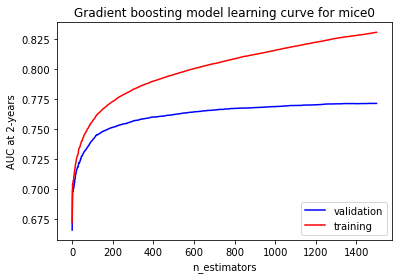

In [125]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm0_staged_auc))
plt.plot(x, gbm0_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm0_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2-years")
plt.title('Gradient boosting model learning curve for mice0')

plt.show()

In [126]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm0_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm0_staged_auc[x:x+24]))

In [127]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm0_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm0_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 1375
Validation dataset AUC before degrading: 0.7711109027150012
Training dataset AUC before degrading: 0.8273283153201054


In [128]:
print(train_mice0_x.shape)
print(train_y.shape)

(27452, 148)
(27452,)


In [129]:
pipe = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(np.where(np.diff(mean_auc_list) < 0)[0][0]*25,
                                                                        learning_rate = 0.05,
                                                                        random_state = 42))

# 3 fold cross-validation
cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__gradientboostingsurvivalanalysis__max_depth': [2, 3, 4], 
              'estimator__gradientboostingsurvivalanalysis__subsample': [0.5, 0.75, 0.9]}

gbm_search = HalvingGridSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 730),
    param_grid,
    cv = cv,
    factor = 2,
    resource = 'n_samples',
    refit = False,
    verbose = 1,
    random_state = 42,
    n_jobs = -1)

# Run search 
warnings.filterwarnings('ignore')
gbm_search.fit(train_mice0_x, train_y)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 3431
max_resources_: 27452
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 9
n_resources: 3431
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 1
n_candidates: 5
n_resources: 6862
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 3
n_resources: 13724
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 2
n_resources: 27448
Fitting 3 folds for each of 2 candidates, totalling 6 fits


HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                    estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                          ColumnTransformer(remainder='passthrough',
                                                                                                            transformers=[('num',
                                                                                                                           Pipeline(steps=[('std_scaler',
                                                                                                                                            StandardScaler())]),
                                                                                                                           ['age',
                                                                                                 

In [130]:
gbm_search.best_params_

{'estimator__gradientboostingsurvivalanalysis__max_depth': 4,
 'estimator__gradientboostingsurvivalanalysis__subsample': 0.75}

In [131]:
gbm_search_results = pd.DataFrame(gbm_search.cv_results_)

In [132]:
gbm_search_results.sort_values(by = 'rank_test_score').head(10)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__gradientboostingsurvivalanalysis__max_depth,param_estimator__gradientboostingsurvivalanalysis__subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0,3431,0.078835,0.001342,0.0,0.0,2,0.5,{'estimator__gradientboostingsurvivalanalysis_...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
16,2,13724,0.058760,0.005589,0.0,0.0,4,0.9,{'estimator__gradientboostingsurvivalanalysis_...,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
15,2,13724,0.077491,0.003627,0.0,0.0,4,0.75,{'estimator__gradientboostingsurvivalanalysis_...,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN
14,2,13724,0.062741,0.002501,0.0,0.0,4,0.5,{'estimator__gradientboostingsurvivalanalysis_...,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN
13,1,6862,0.036771,0.003473,0.0,0.0,4,0.9,{'estimator__gradientboostingsurvivalanalysis_...,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN
12,1,6862,0.041902,0.000991,0.0,0.0,4,0.75,{'estimator__gradientboostingsurvivalanalysis_...,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN
11,1,6862,0.041911,0.001086,0.0,0.0,4,0.5,{'estimator__gradientboostingsurvivalanalysis_...,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN
10,1,6862,0.038414,0.000652,0.0,0.0,3,0.9,{'estimator__gradientboostingsurvivalanalysis_...,NaN,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN
17,3,27448,0.125919,0.007822,0.0,0.0,4,0.75,{'estimator__gradientboostingsurvivalanalysis_...,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN
9,1,6862,0.042208,0.002566,0.0,0.0,3,0.75,{'estimator__gradientboostingsurvivalanalysis_...,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN


**The above best tree depth and subsample will be used for all models moving forward mainly due to the computational cost of searching for these parameters for each MICE training set. It also seems likely that these two hyperparamters have small impact on test set AUC performance and are unlikely to change by much for each training set.** 

#### Building model and assessing performance 

In [133]:
gbm_mice0 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean_auc_list) < 0)[0][0]*25,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 4,
                                                                             subsample = 0.75,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice0.fit(train_mice0_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1      115853.5079          24.2994          218.99m
         2      115462.8345          22.4971          219.04m
         3      115754.8024          21.9986          219.10m
         4      115725.4951          20.9057          219.17m
         5      115211.9880          19.9196          219.15m
         6      115337.0394          19.4266          219.12m
         7      115561.2511          18.1392          219.09m
         8      115809.0132          18.1294          219.28m
         9      115516.0633          17.2445          219.06m
        10      115279.1094          17.7340          218.63m
        20      114947.3252          11.5125          215.90m
        30      114548.3294           8.4601          213.75m
        40      113670.2730           7.0198          211.84m
        50      113844.2823           5.5007          210.14m
        60      113485.6436           4.6104          208.42m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                                   'bicarb_diag', 'bun_diag',
                                                   'calcium_diag', 'cea_diag',
                                                   'chloride_di...


In [134]:
dump(gbm_mice0, 'gbm_mice0.joblib') 

['gbm_mice0.joblib']

In [135]:
gbm_risk_scores_te = gbm_mice0.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', gbm_auc_te)

Test set AUC at 2 years: 0.7824983290412124


In [136]:
gbm_risk_scores_tr = gbm_mice0.predict(train_mice0_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', gbm_auc_tr)

Training set AUC at 2 years: 0.8514906952328514


In [137]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [138]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.002785059870401144


In [139]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [140]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.002568813402589431


In [141]:
mice_auc_data = {'mice_dataset': ['mice_0'],
                 'auc_2yr_te': [gbm_auc_te],
                 'sem_te': [standard_error_te],
                 'auc_2yr_tr': [gbm_auc_tr],
                 'sem_tr': [standard_error_tr]}

mice_auc_df = pd.DataFrame(mice_auc_data)

In [142]:
mice_auc_df

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.782498,0.002785,0.851491,0.002569


In [143]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [144]:
times = np.arange(30, 1810, 30)
mice0_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice0_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice_auc_over5 = pd.DataFrame(times_data, index = ['mice_0'])

In [145]:
mice_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.88861,0.903288,0.884143,0.869969,0.864156,0.855605,0.849778,0.844226,0.839047,0.831123,...,0.750106,0.749444,0.747275,0.745356,0.746439,0.744329,0.745306,0.748618,0.746243,0.746946


In [146]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [147]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice0_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 194
Number of non-zero features in final model: 192


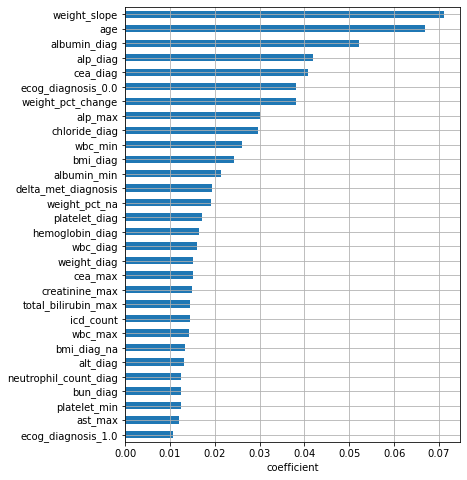

In [148]:
# Dataframe of coefficients for each variable 
coefficients_mice0 = pd.DataFrame(
    gbm_mice0.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice0.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice0.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [149]:
coefficients_mice = (
    coefficients_mice0
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [150]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### 3.2 Model 1

#### Preprocessing and building pipeline 

In [151]:
# Import second training set
train_mice1 = pd.read_csv('mice_tr1.csv', index_col = 'PatientID')

In [152]:
print(train_mice1.shape)

(27452, 185)


In [153]:
train_mice1.isna().sum().sum()

0

In [154]:
train_mice1 = train_mice1.drop(columns = mice_drop)

In [155]:
print(train_mice1.shape)
print(test_mice.shape)

(27452, 147)
(34315, 150)


In [156]:
train_mice1['ecog_na'] = np.where(train_mice1.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice1['stage_na'] = np.where(train_mice1.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)
train_mice1['ses_na'] = np.where(train_mice1.index.isin(train[train['ses'].isnull()].PatientID), 1, 0)

In [157]:
for x in list(to_be_categorical):
    train_mice1[x] = train_mice1[x].astype('category')
    
list(train_mice1.select_dtypes(include = ['category']).columns)

['gender',
 'race',
 'ethnicity',
 'p_type',
 'region',
 'stage',
 'met_year',
 'crc_site',
 'KRAS',
 'dMMR_MSIh',
 'NRAS',
 'BRAF',
 'ecog_diagnosis',
 'ses']

In [158]:
train_mice1['death_status'] = train_mice1['death_status'].astype('bool')

In [159]:
val_mice1 = train_mice1[train_mice1.index.isin(val_IDs['PatientID'])]

sub_train_mice1 = train_mice1[~train_mice1.index.isin(val_IDs['PatientID'])]

In [160]:
print(train_mice1.shape)
print(sub_train_mice1.shape)
print(val_mice1.shape)

(27452, 150)
(20589, 150)
(6863, 150)


In [161]:
train_mice1_x = train_mice1.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice1_x = sub_train_mice1.drop(columns = ['death_status', 'timerisk_activity'])

val_mice1_x = val_mice1.drop(columns = ['death_status', 'timerisk_activity'])

In [162]:
print(train_mice1_x.shape)
print(sub_train_mice1_x.shape)
print(val_mice1_x.shape)

(27452, 148)
(20589, 148)
(6863, 148)


#### Hyperparameter tuning 

In [163]:
sub_train_mice1_xt = preprocessor_red.fit_transform(sub_train_mice1_x)
val_mice1_xt = preprocessor_red.transform(val_mice1_x)

gbm_mice1_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                                 learning_rate = 0.05,
                                                 max_depth = 4,
                                                 subsample = 0.75,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice1_exp.fit(sub_train_mice1_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       84779.3623          17.3192          135.23m
         2       84197.9546          17.9614          135.68m
         3       84038.5829          16.4311          135.65m
         4       84217.4895          15.4635          135.44m
         5       84217.5526          14.3841          135.13m
         6       84351.2555          13.4458          134.92m
         7       83971.8719          13.5842          134.82m
         8       84228.0847          13.0834          134.60m
         9       83759.6775          12.9376          134.43m
        10       83478.5765          12.7548          134.25m
        20       83965.2386           9.2999          132.99m
        30       83039.5231           6.2839          131.91m
        40       82763.4198           5.4778          130.82m
        50       83007.5213           4.8992          129.84m
        60       83316.3249           3.0159          128.88m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, max_depth=4,
                                 n_estimators=1500, random_state=42,
                                 subsample=0.75, verbose=1)

In [164]:
gbm1_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_mice1_exp.staged_predict(val_mice1_xt)]

In [165]:
gbm1_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_mice1_exp.staged_predict(sub_train_mice1_xt)]

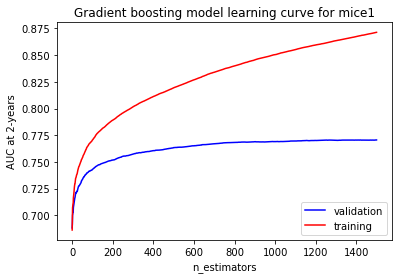

In [166]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm1_staged_auc))
plt.plot(x, gbm1_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm1_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2-years")
plt.title('Gradient boosting model learning curve for mice1')

plt.show()

In [167]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm1_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm1_staged_auc[x:x+24]))

In [168]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm1_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm1_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 900
Validation dataset AUC before degrading: 0.7689604477995469
Training dataset AUC before degrading: 0.845624679765183


#### Building model and assessing performance 

In [169]:
gbm_mice1 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean_auc_list) < 0)[0][0]*25,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 4,
                                                                             subsample = 0.75,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice1.fit(train_mice1_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1      115853.3566          23.6645          144.14m
         2      115459.4543          22.3193          143.94m
         3      115753.2939          21.6242          144.23m
         4      115720.7876          20.0694          143.96m
         5      115210.1272          19.9505          143.74m
         6      115336.2405          19.3432          143.48m
         7      115566.7127          16.8332          143.25m
         8      115805.8560          17.3411          143.10m
         9      115516.6513          17.0648          142.88m
        10      115278.6140          16.8639          142.65m
        20      114946.6651          11.8798          140.69m
        30      114554.2647           8.9540          138.96m
        40      113671.5148           6.7887          137.26m
        50      113831.5152           6.4693          135.66m
        60      113502.9581           5.1334          134.10m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                                   'bicarb_diag', 'bun_diag',
                                                   'calcium_diag', 'cea_diag',
                                                   'chloride_di...


In [170]:
dump(gbm_mice1, 'gbm_mice1.joblib') 

['gbm_mice1.joblib']

In [171]:
gbm_risk_scores_te = gbm_mice1.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', gbm_auc_te)

Test set AUC at 2 years: 0.7795695792439274


In [172]:
gbm_risk_scores_tr = gbm_mice1.predict(train_mice1_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', gbm_auc_tr)

Training set AUC at 2 years: 0.8310945173814785


In [173]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [174]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.002796750905250061


In [175]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [176]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.002769567459328931


In [177]:
mice_auc_data = {'mice_dataset': 'mice_1',
                 'auc_2yr_te': gbm_auc_te,
                 'sem_te': standard_error_te,
                 'auc_2yr_tr': gbm_auc_tr,
                 'sem_tr': standard_error_tr}

mice_auc_df = mice_auc_df.append(mice_auc_data, ignore_index = True)

In [178]:
mice_auc_df 

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.782498,0.002785,0.851491,0.002569
1,mice_1,0.779570,0.002797,0.831095,0.002770


In [179]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [180]:
times = np.arange(30, 1810, 30)
mice1_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice1_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice1_auc_over5_df = pd.DataFrame(times_data, index = ['mice_1'])

mice_auc_over5 = mice_auc_over5.append(mice1_auc_over5_df, ignore_index = False)

In [181]:
mice_auc_over5 

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.888610,0.903288,0.884143,0.869969,0.864156,0.855605,0.849778,0.844226,0.839047,0.831123,...,0.750106,0.749444,0.747275,0.745356,0.746439,0.744329,0.745306,0.748618,0.746243,0.746946
mice_1,0.880479,0.900101,0.882442,0.867095,0.861430,0.852466,0.845465,0.839978,0.834610,0.827169,...,0.747287,0.746900,0.745429,0.742912,0.744363,0.742582,0.744016,0.746965,0.744604,0.745888


In [182]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [183]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice1_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 194
Number of non-zero features in final model: 191


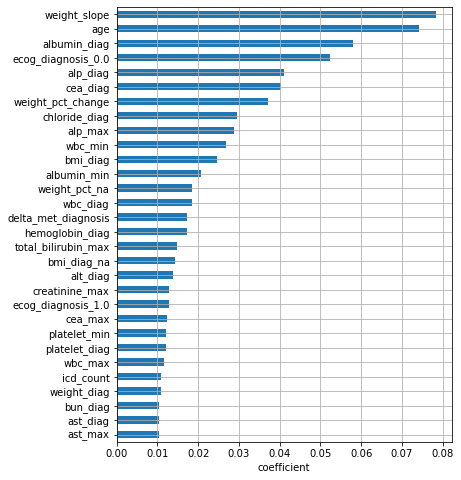

In [184]:
# Dataframe of coefficients for each variable 
coefficients_mice1 = pd.DataFrame(
    gbm_mice1.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice1.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice1.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [185]:
coefficients_mice1_df = (
    coefficients_mice1
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [186]:
coefficients_mice = coefficients_mice.append(coefficients_mice1_df, ignore_index = True)

In [187]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### 3.3 Model 3

#### Preprocessing 

In [188]:
train_mice2 = pd.read_csv('mice_tr2.csv', index_col = 'PatientID')

In [189]:
print(train_mice2.shape)

(27452, 185)


In [190]:
train_mice2.isna().sum().sum()

0

In [191]:
train_mice2 = train_mice2.drop(columns = mice_drop)

In [192]:
print(train_mice2.shape)

(27452, 147)


In [193]:
train_mice2['ecog_na'] = np.where(train_mice2.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice2['stage_na'] = np.where(train_mice2.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)
train_mice2['ses_na'] = np.where(train_mice2.index.isin(train[train['ses'].isnull()].PatientID), 1, 0)

In [194]:
for x in list(to_be_categorical):
    train_mice2[x] = train_mice2[x].astype('category')
    
list(train_mice2.select_dtypes(include = ['category']).columns)

['gender',
 'race',
 'ethnicity',
 'p_type',
 'region',
 'stage',
 'met_year',
 'crc_site',
 'KRAS',
 'dMMR_MSIh',
 'NRAS',
 'BRAF',
 'ecog_diagnosis',
 'ses']

In [195]:
train_mice2['death_status'] = train_mice2['death_status'].astype('bool')

In [196]:
val_mice2 = train_mice2[train_mice2.index.isin(val_IDs['PatientID'])]

sub_train_mice2 = train_mice2[~train_mice2.index.isin(val_IDs['PatientID'])]

In [197]:
print(train_mice2.shape)
print(sub_train_mice2.shape)
print(val_mice2.shape)

(27452, 150)
(20589, 150)
(6863, 150)


In [198]:
train_mice2_x = train_mice2.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice2_x = sub_train_mice2.drop(columns = ['death_status', 'timerisk_activity'])

val_mice2_x = val_mice2.drop(columns = ['death_status', 'timerisk_activity'])

In [199]:
print(train_mice2_x.shape)
print(sub_train_mice2_x.shape)
print(val_mice2_x.shape)

(27452, 148)
(20589, 148)
(6863, 148)


#### Hyperparameter tuning 

In [200]:
sub_train_mice2_xt = preprocessor_red.fit_transform(sub_train_mice2_x)
val_mice2_xt = preprocessor_red.transform(val_mice2_x)

gbm_mice2_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                                 learning_rate = 0.05,
                                                 max_depth = 4,
                                                 subsample = 0.75,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice2_exp.fit(sub_train_mice2_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       84782.0943          17.0946          134.35m
         2       84201.2296          17.0183          134.17m
         3       84045.7972          16.0126          134.38m
         4       84224.2509          14.9289          134.25m
         5       84224.6290          15.3178          134.24m
         6       84358.4313          13.8777          134.14m
         7       83976.4189          12.6683          133.96m
         8       84232.6085          13.2877          133.75m
         9       83764.2372          12.7093          133.61m
        10       83484.0680          11.9574          133.49m
        20       83975.5950           8.5287          132.49m
        30       83056.7967           6.3177          131.49m
        40       82779.9000           4.6552          130.51m
        50       83016.1301           3.8586          129.58m
        60       83326.3743           3.3364          128.68m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, max_depth=4,
                                 n_estimators=1500, random_state=42,
                                 subsample=0.75, verbose=1)

In [201]:
gbm2_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_mice2_exp.staged_predict(val_mice2_xt)]

In [202]:
gbm2_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_mice2_exp.staged_predict(sub_train_mice2_xt)]

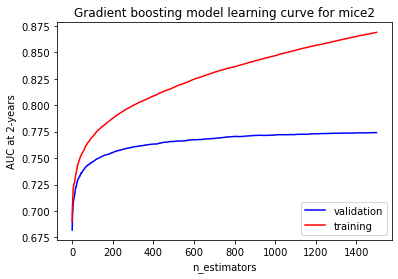

In [203]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm2_staged_auc))
plt.plot(x, gbm2_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm2_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2-years")
plt.title('Gradient boosting model learning curve for mice2')

plt.show()

In [204]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm2_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm2_staged_auc[x:x+24]))

In [205]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm2_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm2_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 1025
Validation dataset AUC before degrading: 0.7722363243547238
Training dataset AUC before degrading: 0.848391653835163


In [206]:
print(train_mice2_x.shape)
print(train_y.shape)

(27452, 148)
(27452,)


#### Building model and assessing performance

In [207]:
gbm_mice2 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean_auc_list) < 0)[0][0]*25,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 4,
                                                                             subsample = 0.75,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice2.fit(train_mice2_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1      115856.5606          23.1952          162.40m
         2      115465.8798          22.2201          162.58m
         3      115761.6184          20.7767          162.53m
         4      115736.2544          21.7917          162.42m
         5      115219.0675          18.9402          162.32m
         6      115347.7601          19.9089          162.19m
         7      115574.0501          16.7440          162.16m
         8      115819.4904          17.8834          162.00m
         9      115535.5810          17.0456          161.85m
        10      115290.7221          16.7642          161.69m
        20      114960.7365          11.3997          160.24m
        30      114568.1627           8.8015          158.61m
        40      113698.5830           6.9810          157.08m
        50      113864.0640           5.8866          155.43m
        60      113514.6651           4.6732          153.88m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                                   'bicarb_diag', 'bun_diag',
                                                   'calcium_diag', 'cea_diag',
                                                   'chloride_di...


In [208]:
dump(gbm_mice2, 'gbm_mice2.joblib') 

['gbm_mice2.joblib']

In [209]:
gbm_risk_scores_te = gbm_mice2.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 year:', gbm_auc_te)

Test set AUC at 2 year: 0.779861370825464


In [210]:
gbm_risk_scores_tr = gbm_mice2.predict(train_mice2_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 year:', gbm_auc_tr)

Training set AUC at 2 year: 0.8356078775726585


In [211]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [212]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.002819002855470615


In [213]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [214]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.0027338520789268904


In [215]:
mice_auc_data = {'mice_dataset': 'mice_2',
                 'auc_2yr_te': gbm_auc_te,
                 'sem_te': standard_error_te,
                 'auc_2yr_tr': gbm_auc_tr,
                 'sem_tr': standard_error_tr}

mice_auc_df = mice_auc_df.append(mice_auc_data, ignore_index = True)

In [216]:
mice_auc_df 

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.782498,0.002785,0.851491,0.002569
1,mice_1,0.779570,0.002797,0.831095,0.002770
2,mice_2,0.779861,0.002819,0.835608,0.002734


In [217]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [218]:
times = np.arange(30, 1810, 30)
mice2_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice2_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice2_auc_over5_df = pd.DataFrame(times_data, index = ['mice_2'])

mice_auc_over5 = mice_auc_over5.append(mice2_auc_over5_df, ignore_index = False)

In [219]:
mice_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.888610,0.903288,0.884143,0.869969,0.864156,0.855605,0.849778,0.844226,0.839047,0.831123,...,0.750106,0.749444,0.747275,0.745356,0.746439,0.744329,0.745306,0.748618,0.746243,0.746946
mice_1,0.880479,0.900101,0.882442,0.867095,0.861430,0.852466,0.845465,0.839978,0.834610,0.827169,...,0.747287,0.746900,0.745429,0.742912,0.744363,0.742582,0.744016,0.746965,0.744604,0.745888
mice_2,0.886631,0.903260,0.884247,0.868483,0.862370,0.853971,0.848447,0.842964,0.838200,0.830562,...,0.747902,0.747874,0.745646,0.742923,0.744334,0.742909,0.744376,0.747515,0.745148,0.747075


In [220]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [221]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice2_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 194
Number of non-zero features in final model: 192


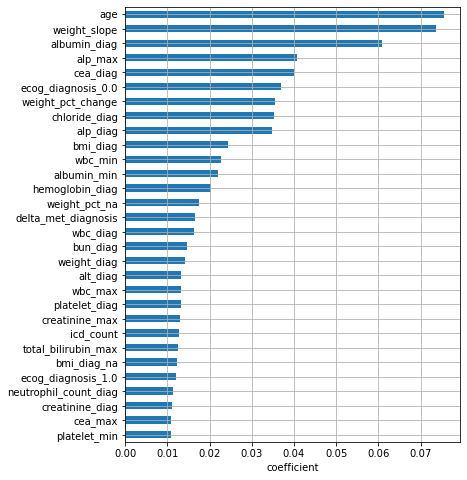

In [222]:
# Dataframe of coefficients for each variable 
coefficients_mice2 = pd.DataFrame(
    gbm_mice2.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice2.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice2.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [223]:
coefficients_mice2_df = (
    coefficients_mice2
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [224]:
coefficients_mice = coefficients_mice.append(coefficients_mice2_df, ignore_index = True)

In [225]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### 3.4 Model 4

#### Preprocessing 

In [226]:
train_mice3 = pd.read_csv('mice_tr3.csv', index_col = 'PatientID')

In [227]:
print(train_mice3.shape)

(27452, 185)


In [228]:
train_mice3.isna().sum().sum()

0

In [229]:
train_mice3 = train_mice3.drop(columns = mice_drop)

In [230]:
print(train_mice3.shape)

(27452, 147)


In [231]:
train_mice3['ecog_na'] = np.where(train_mice3.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice3['stage_na'] = np.where(train_mice3.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)
train_mice3['ses_na'] = np.where(train_mice3.index.isin(train[train['ses'].isnull()].PatientID), 1, 0)

In [232]:
for x in list(to_be_categorical):
    train_mice3[x] = train_mice3[x].astype('category')
    
list(train_mice3.select_dtypes(include = ['category']).columns)

['gender',
 'race',
 'ethnicity',
 'p_type',
 'region',
 'stage',
 'met_year',
 'crc_site',
 'KRAS',
 'dMMR_MSIh',
 'NRAS',
 'BRAF',
 'ecog_diagnosis',
 'ses']

In [233]:
train_mice3['death_status'] = train_mice3['death_status'].astype('bool')

In [234]:
val_mice3 = train_mice3[train_mice3.index.isin(val_IDs['PatientID'])]

sub_train_mice3 = train_mice3[~train_mice3.index.isin(val_IDs['PatientID'])]

In [235]:
print(train_mice3.shape)
print(sub_train_mice3.shape)
print(val_mice3.shape)

(27452, 150)
(20589, 150)
(6863, 150)


In [236]:
train_mice3_x = train_mice3.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice3_x = sub_train_mice3.drop(columns = ['death_status', 'timerisk_activity'])

val_mice3_x = val_mice3.drop(columns = ['death_status', 'timerisk_activity'])

In [237]:
print(train_mice3_x.shape)
print(sub_train_mice3_x.shape)
print(val_mice3_x.shape)

(27452, 148)
(20589, 148)
(6863, 148)


#### Hyperparameter tuning 

In [238]:
sub_train_mice3_xt = preprocessor_red.fit_transform(sub_train_mice3_x)
val_mice3_xt = preprocessor_red.transform(val_mice3_x)

gbm_mice3_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                                 learning_rate = 0.05,
                                                 max_depth = 3,
                                                 subsample = 0.75,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice3_exp.fit(sub_train_mice3_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       84790.2550          15.3266          131.89m
         2       84217.8778          15.0678          131.93m
         3       84068.3947          13.4280          131.86m
         4       84259.3194          12.5210          131.81m
         5       84267.7834          12.1750          131.73m
         6       84411.9378          11.3706          131.66m
         7       84039.0003          11.6088          131.61m
         8       84297.9414          11.0093          131.54m
         9       83841.4257          11.7304          131.56m
        10       83562.8549          10.8202          131.48m
        20       84114.0954           7.9615          130.55m
        30       83230.4416           6.0615          129.61m
        40       82989.8119           5.8819          128.89m
        50       83266.0065           4.1693          128.21m
        60       83595.8078           3.2599          127.43m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, n_estimators=1500,
                                 random_state=42, subsample=0.75, verbose=1)

In [239]:
gbm3_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_mice3_exp.staged_predict(val_mice3_xt)]

In [240]:
gbm3_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_mice3_exp.staged_predict(sub_train_mice3_xt)]

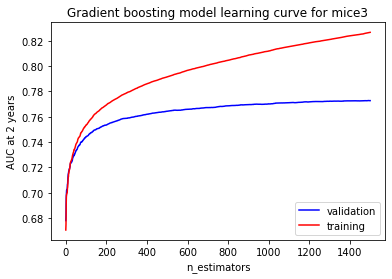

In [241]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm3_staged_auc))
plt.plot(x, gbm3_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm3_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2 years")
plt.title('Gradient boosting model learning curve for mice3')

plt.show()

In [242]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm3_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm3_staged_auc[x:x+24]))

In [243]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm3_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm3_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 925
Validation dataset AUC before degrading: 0.7697548217746023
Training dataset AUC before degrading: 0.8094569850550084


In [244]:
print(train_mice3_x.shape)
print(train_y.shape)

(27452, 148)
(27452,)


#### Model building and performance assessment 

In [245]:
gbm_mice3 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean_auc_list) < 0)[0][0]*25,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 4,
                                                                             subsample = 0.75,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice3.fit(train_mice3_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1      115853.9173          24.3254          147.87m
         2      115462.3845          22.1564          147.66m
         3      115755.6414          20.6709          148.14m
         4      115726.2555          21.4510          147.92m
         5      115211.8927          20.1112          147.71m
         6      115336.8731          19.7753          147.43m
         7      115565.8695          16.9573          147.30m
         8      115811.8404          17.7220          147.02m
         9      115518.7697          17.7681          146.86m
        10      115277.1284          16.5990          146.66m
        20      114953.7653          12.4977          144.76m
        30      114568.3634           8.7369          143.08m
        40      113685.4277           7.4902          141.41m
        50      113845.6670           6.0884          139.80m
        60      113514.0974           3.7911          138.17m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                                   'bicarb_diag', 'bun_diag',
                                                   'calcium_diag', 'cea_diag',
                                                   'chloride_di...


In [246]:
dump(gbm_mice3, 'gbm_mice3.joblib') 

['gbm_mice3.joblib']

In [247]:
gbm_risk_scores_te = gbm_mice3.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', gbm_auc_te)

Test set AUC at 2 years: 0.7792773529810073


In [248]:
gbm_risk_scores_tr = gbm_mice3.predict(train_mice3_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', gbm_auc_tr)

Training set AUC at 2 years: 0.8314982902714564


In [249]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [250]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.002812970755941161


In [251]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [252]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.0027869758272653093


In [253]:
mice_auc_data = {'mice_dataset': 'mice_3',
                 'auc_2yr_te': gbm_auc_te,
                 'sem_te': standard_error_te,
                 'auc_2yr_tr': gbm_auc_tr,
                 'sem_tr': standard_error_tr}

mice_auc_df = mice_auc_df.append(mice_auc_data, ignore_index = True)

In [254]:
mice_auc_df 

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.782498,0.002785,0.851491,0.002569
1,mice_1,0.779570,0.002797,0.831095,0.002770
2,mice_2,0.779861,0.002819,0.835608,0.002734
3,mice_3,0.779277,0.002813,0.831498,0.002787


In [255]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [256]:
times = np.arange(30, 1810, 30)
mice3_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice3_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice3_auc_over5_df = pd.DataFrame(times_data, index = ['mice_3'])

mice_auc_over5 = mice_auc_over5.append(mice3_auc_over5_df, ignore_index = False)

In [257]:
mice_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.888610,0.903288,0.884143,0.869969,0.864156,0.855605,0.849778,0.844226,0.839047,0.831123,...,0.750106,0.749444,0.747275,0.745356,0.746439,0.744329,0.745306,0.748618,0.746243,0.746946
mice_1,0.880479,0.900101,0.882442,0.867095,0.861430,0.852466,0.845465,0.839978,0.834610,0.827169,...,0.747287,0.746900,0.745429,0.742912,0.744363,0.742582,0.744016,0.746965,0.744604,0.745888
mice_2,0.886631,0.903260,0.884247,0.868483,0.862370,0.853971,0.848447,0.842964,0.838200,0.830562,...,0.747902,0.747874,0.745646,0.742923,0.744334,0.742909,0.744376,0.747515,0.745148,0.747075
mice_3,0.879703,0.901007,0.880850,0.865499,0.859965,0.851633,0.845671,0.840144,0.834420,0.827436,...,0.750114,0.750168,0.748035,0.745512,0.747532,0.746046,0.747755,0.750728,0.748913,0.749524


In [258]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [259]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice3_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 194
Number of non-zero features in final model: 192


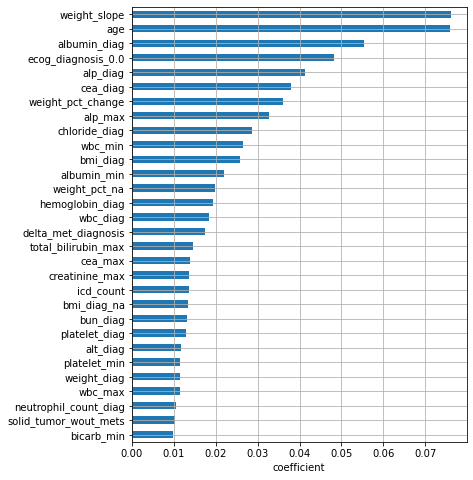

In [260]:
# Dataframe of coefficients for each variable 
coefficients_mice3 = pd.DataFrame(
    gbm_mice3.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice3.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice3.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [261]:
coefficients_mice3_df = (
    coefficients_mice3
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [262]:
coefficients_mice = coefficients_mice.append(coefficients_mice3_df, ignore_index = True)

In [263]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### 3.5 Model 5

#### Preprocessing

In [264]:
train_mice4 = pd.read_csv('mice_tr4.csv', index_col = 'PatientID')

In [265]:
train_mice4.shape

(27452, 185)

In [266]:
train_mice4.isna().sum().sum()

0

In [267]:
train_mice4 = train_mice4.drop(columns = mice_drop)

In [268]:
print(train_mice4.shape)

(27452, 147)


In [269]:
train_mice4['ecog_na'] = np.where(train_mice4.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice4['stage_na'] = np.where(train_mice4.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)
train_mice4['ses_na'] = np.where(train_mice4.index.isin(train[train['ses'].isnull()].PatientID), 1, 0)

In [270]:
for x in list(to_be_categorical):
    train_mice4[x] = train_mice4[x].astype('category')
    
list(train_mice4.select_dtypes(include = ['category']).columns)

['gender',
 'race',
 'ethnicity',
 'p_type',
 'region',
 'stage',
 'met_year',
 'crc_site',
 'KRAS',
 'dMMR_MSIh',
 'NRAS',
 'BRAF',
 'ecog_diagnosis',
 'ses']

In [271]:
train_mice4['death_status'] = train_mice4['death_status'].astype('bool')

In [272]:
val_mice4 = train_mice4[train_mice4.index.isin(val_IDs['PatientID'])]

sub_train_mice4 = train_mice4[~train_mice4.index.isin(val_IDs['PatientID'])]

In [273]:
print(train_mice4.shape)
print(sub_train_mice4.shape)
print(val_mice4.shape)

(27452, 150)
(20589, 150)
(6863, 150)


In [274]:
train_mice4_x = train_mice4.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice4_x = sub_train_mice4.drop(columns = ['death_status', 'timerisk_activity'])

val_mice4_x = val_mice4.drop(columns = ['death_status', 'timerisk_activity'])

In [275]:
print(train_mice4_x.shape)
print(sub_train_mice4_x.shape)
print(val_mice4_x.shape)

(27452, 148)
(20589, 148)
(6863, 148)


#### Hyperparameter tuning

In [276]:
sub_train_mice4_xt = preprocessor_red.fit_transform(sub_train_mice4_x)
val_mice4_xt = preprocessor_red.transform(val_mice4_x)

gbm_mice4_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                                 learning_rate = 0.05,
                                                 max_depth = 4,
                                                 subsample = 0.75,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice4_exp.fit(sub_train_mice4_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       84777.7666          18.1555          135.85m
         2       84196.4132          18.2317          135.76m
         3       84041.6868          15.7978          135.31m
         4       84219.3677          15.3320          135.03m
         5       84219.8022          14.2681          135.13m
         6       84355.2196          13.9445          134.89m
         7       83975.3290          12.8872          134.76m
         8       84228.5937          13.0758          134.76m
         9       83760.3670          12.7975          134.56m
        10       83486.4603          12.2834          134.40m
        20       83969.9665           8.9647          133.23m
        30       83051.9473           6.2299          132.13m
        40       82783.3088           4.5266          131.08m
        50       83037.2914           3.9026          130.07m
        60       83328.4001           3.9210          129.09m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, max_depth=4,
                                 n_estimators=1500, random_state=42,
                                 subsample=0.75, verbose=1)

In [277]:
gbm4_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_mice4_exp.staged_predict(val_mice4_xt)]

In [278]:
gbm4_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_mice4_exp.staged_predict(sub_train_mice4_xt)]

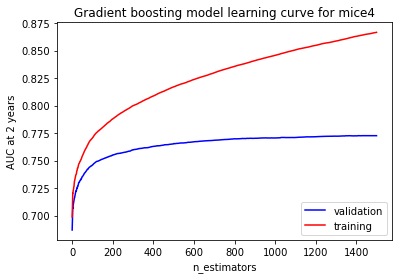

In [279]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm4_staged_auc))
plt.plot(x, gbm4_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm4_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2 years")
plt.title('Gradient boosting model learning curve for mice4')

plt.show()

In [280]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm4_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm4_staged_auc[x:x+24]))

In [281]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm4_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm4_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 950
Validation dataset AUC before degrading: 0.7706724384448883
Training dataset AUC before degrading: 0.8433965245240238


In [282]:
print(train_mice4_x.shape)
print(train_y.shape)

(27452, 148)
(27452,)


#### Model building and performance asssessment 

In [283]:
gbm_mice4 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean_auc_list) < 0)[0][0]*25,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 3,
                                                                             subsample = 0.5,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice4.fit(train_mice4_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       74062.7226          39.9403          151.91m
         2       72768.6826          36.7539          152.47m
         3       73489.7997          35.3697          152.67m
         4       74391.1093          34.8188          152.66m
         5       73448.7226          34.8336          152.48m
         6       73162.5853          32.2112          152.39m
         7       73802.0777          30.5700          152.25m
         8       73883.1382          29.5048          152.06m
         9       73456.3454          28.9502          151.89m
        10       73782.3282          27.2894          151.83m
        20       72815.3616          21.1391          150.27m
        30       73093.1802          17.2202          148.73m
        40       72808.7319          13.5869          147.04m
        50       72940.6611          10.5247          145.38m
        60       72244.5347           8.4048          143.77m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_met_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                                   'bicarb_diag', 'bun_diag',
                                                   'calcium_diag', 'cea_diag',
                                                   'chloride_di...


In [284]:
dump(gbm_mice4, 'gbm_mice4.joblib') 

['gbm_mice4.joblib']

In [285]:
gbm_risk_scores_te = gbm_mice4.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', gbm_auc_te)

Test set AUC at 2 years: 0.7754208221582329


In [286]:
gbm_risk_scores_tr = gbm_mice4.predict(train_mice4_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', gbm_auc_tr)

Training set AUC at 2 years: 0.8019853088110656


In [287]:
# Bootstrap 10000 2 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [288]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.002863177262279289


In [289]:
# Bootstrap 10000 2 yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [290]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.0030502282286447614


In [291]:
mice_auc_data = {'mice_dataset': 'mice_4',
                 'auc_2yr_te': gbm_auc_te,
                 'sem_te': standard_error_te,
                 'auc_2yr_tr': gbm_auc_tr,
                 'sem_tr': standard_error_tr}

mice_auc_df = mice_auc_df.append(mice_auc_data, ignore_index = True)

In [292]:
mice_auc_df 

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.782498,0.002785,0.851491,0.002569
1,mice_1,0.779570,0.002797,0.831095,0.002770
2,mice_2,0.779861,0.002819,0.835608,0.002734
3,mice_3,0.779277,0.002813,0.831498,0.002787
4,mice_4,0.775421,0.002863,0.801985,0.003050


In [293]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [294]:
times = np.arange(30, 1810, 30)
mice4_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice4_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice4_auc_over5_df = pd.DataFrame(times_data, index = ['mice_4'])

mice_auc_over5 = mice_auc_over5.append(mice4_auc_over5_df, ignore_index = False)

In [295]:
mice_auc_over5 

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.888610,0.903288,0.884143,0.869969,0.864156,0.855605,0.849778,0.844226,0.839047,0.831123,...,0.750106,0.749444,0.747275,0.745356,0.746439,0.744329,0.745306,0.748618,0.746243,0.746946
mice_1,0.880479,0.900101,0.882442,0.867095,0.861430,0.852466,0.845465,0.839978,0.834610,0.827169,...,0.747287,0.746900,0.745429,0.742912,0.744363,0.742582,0.744016,0.746965,0.744604,0.745888
mice_2,0.886631,0.903260,0.884247,0.868483,0.862370,0.853971,0.848447,0.842964,0.838200,0.830562,...,0.747902,0.747874,0.745646,0.742923,0.744334,0.742909,0.744376,0.747515,0.745148,0.747075
mice_3,0.879703,0.901007,0.880850,0.865499,0.859965,0.851633,0.845671,0.840144,0.834420,0.827436,...,0.750114,0.750168,0.748035,0.745512,0.747532,0.746046,0.747755,0.750728,0.748913,0.749524
mice_4,0.883876,0.899395,0.880358,0.864756,0.857891,0.849996,0.843763,0.837739,0.832711,0.824100,...,0.744723,0.744724,0.742109,0.738983,0.741044,0.738381,0.738855,0.742448,0.740151,0.741271


In [296]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [297]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice4_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 194
Number of non-zero features in final model: 184


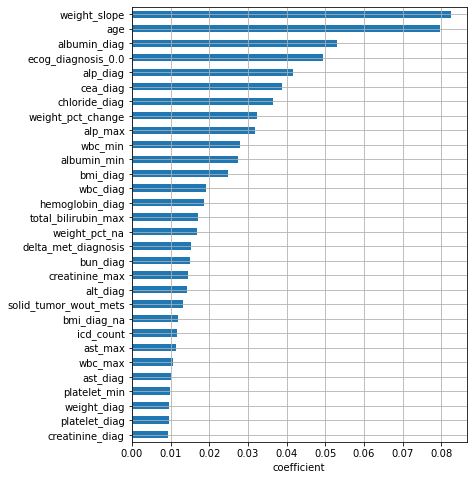

In [298]:
# Dataframe of coefficients for each variable 
coefficients_mice4 = pd.DataFrame(
    gbm_mice4.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice4.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice4.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [299]:
coefficients_mice4_df = (
    coefficients_mice4
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [300]:
coefficients_mice = coefficients_mice.append(coefficients_mice4_df, ignore_index = True)

In [301]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### Part 4. Pooling results

In [302]:
from math import sqrt, exp 
from scipy.stats import t

**Test and training AUCs will be pooled using Rubin’s rules. This is complicated by the fact that AUCs are bounded and thus not normally distributed. The AUCs will therefore be logit transformed to an unbounded scale, then Rubin's rules will be applied to these values, and finally they will be back-transformed into a final pool estimate.** 

In [303]:
# This function is translated from the R package: "psfmi: Prediction Model Selection and Performance Evaluation in
# Multiple Imputed Datasets"

def pool_auc(auc_arr, se_arr, iterations_n):
    
    # pooled SE using Rubin's rules 
    def rr_se(est, se, iterations_n):
        m = iterations_n
        w_auc = np.mean(np.square(se)) # within variance 
        b_auc = np.var(est) # between variance 
        tv_auc = w_auc + (1 + (1/m)) * b_auc # total vairance 
        se_total = sqrt(tv_auc)
        r = (1 + (1/ m)) * (b_auc / w_auc)
        v = (m - 1) * (1 + (1/r))**2
        w = t.ppf(0.975, v) # Percent point function or inverse CDF with df = v
        res = np.array([se_total, w])
        return(res)
    
    # log transform
    auc_log = np.log(auc_arr / (1-auc_arr))
    se_log = se_arr / (auc_arr * (1-auc_arr))
    
    # input log transfomred auc and se to calculat RR's total se
    se_total = rr_se(auc_log, se_log, iterations_n = iterations_n)
    
    # backtransform 
    inv_auc = exp(np.mean(auc_log)) / (1 + exp(np.mean(auc_log)))
    inv_auc_upper = exp(np.mean(auc_log) + (se_total[1]*se_total[0])) / (1 + exp(np.mean(auc_log) + (se_total[1]*se_total[0])))
    inv_auc_lower = exp(np.mean(auc_log) - (se_total[1]*se_total[0])) / (1 + exp(np.mean(auc_log) - (se_total[1]*se_total[0])))
    sem = (inv_auc_upper - inv_auc_lower) / 3.92
    auc_res = np.round(np.array([inv_auc_lower, inv_auc, inv_auc_upper, sem]), 6)
    return(auc_res)

In [304]:
mice_auc_df = pd.read_csv('mice_auc_df.csv', dtype = {'auc_2yr_te': np.float64,
                                                      'sem_te': np.float64,
                                                      'auc_2yr_tr': np.float64,
                                                      'sem_tr': np.float64})

In [305]:
mice_auc_df

,mice_dataset,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,mice_0,0.782498,0.002785,0.851491,0.002569
1,mice_1,0.779570,0.002797,0.831095,0.002770
2,mice_2,0.779861,0.002819,0.835608,0.002734
3,mice_3,0.779277,0.002813,0.831498,0.002787
4,mice_4,0.775421,0.002863,0.801985,0.003050


In [306]:
pool_auc_test = pool_auc(mice_auc_df['auc_2yr_te'].values, 
                         mice_auc_df['sem_te'].values, 
                         5)

print(pool_auc_test)

[0.771436 0.779334 0.787034 0.003979]


In [307]:
pool_auc_train = pool_auc(mice_auc_df['auc_2yr_tr'].values,
                          mice_auc_df['sem_tr'].values,
                          5)

print(pool_auc_train)

[0.778139 0.830916 0.873185 0.024247]


In [308]:
crude_auc_df = pd.read_csv('crude_auc_df.csv', dtype = {'auc_2yr_te': np.float64,
                                                        'sem_te': np.float64,
                                                        'auc_2yr_tr': np.float64,
                                                        'sem_tr': np.float64})

In [309]:
crude_auc_df

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,gbm_crude,0.768810,0.006324,0.820262,0.002853
1,rsf_crude,0.745188,0.006629,0.888791,0.002143
2,ridge_crude,0.739879,0.006750,0.736821,0.003434
3,lasso_crude,0.721280,0.006921,0.713022,0.003523
4,enet_crude,0.721099,0.006912,0.712810,0.003518
5,linear_svm_crude,0.741701,0.006768,0.741503,0.003424


In [310]:
mice_auc_data = {'model': 'gbm_mice',
                 'auc_2yr_te': pool_auc_test[1],
                 'sem_te': pool_auc_test[3],
                 'auc_2yr_tr': pool_auc_train[1],
                 'sem_tr': pool_auc_train[3]}

In [311]:
ml_auc_df = crude_auc_df.append(mice_auc_data, ignore_index = True)

In [312]:
ml_auc_df.sort_values(by = 'auc_2yr_te', ascending = False)

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
6,gbm_mice,0.779334,0.003979,0.830916,0.024247
0,gbm_crude,0.768810,0.006324,0.820262,0.002853
1,rsf_crude,0.745188,0.006629,0.888791,0.002143
5,linear_svm_crude,0.741701,0.006768,0.741503,0.003424
2,ridge_crude,0.739879,0.006750,0.736821,0.003434
3,lasso_crude,0.721280,0.006921,0.713022,0.003523
4,enet_crude,0.721099,0.006912,0.712810,0.003518


In [313]:
ml_auc_df.to_csv('ml_auc_df.csv', index = False, header = True)